In [ ]:
import re
from pathlib import Path
from pprint import pp

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    PredictionErrorDisplay,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from P03_run_diff_sigma.T00_lib.classes_ml import MyUtil
from P03_run_diff_sigma.T00_lib.utils import check_jupyter


In [159]:
SAVE_DATA = False
MAKE_ONE_HOT = True

In [160]:
if check_jupyter():
    BASE_DIR = Path.cwd()  # Current directory of the running file
    DATA_DIR = BASE_DIR.parent / "T02_combine_features"
    CURRENT_DIR = BASE_DIR
else:
    BASE_DIR = Path.cwd()  # Base directory of the project
    DATA_DIR = BASE_DIR / "src/P3_run_diff_sigma/T02_combine_features"
    CURRENT_DIR = Path(__file__).resolve().parent

dt = MyUtil.get_dt()
print(f"Current Directory: {CURRENT_DIR}")
print(f"Current Date and Time: {dt}")

# Load data
df = pd.read_excel(DATA_DIR / "S02_data_combined_loc.xlsx")
print(df.shape)
df

Code is running in a Jupyter environment.
Current Directory: c:\Users\admin\Coding\research\weld-ml\src\P03_run_diff_sigma\T03_ml_trial
Current Date and Time: 2026-01-22_14-17
(378, 180)


,sample_no,R,W,D,position,location,fz_location,"dwell_Fz__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""",dwell_Fz__mean_change,"dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0",...,"weld_Fz__fft_coefficient__attr_""angle""__coeff_26","weld_Fz__fft_coefficient__attr_""angle""__coeff_86","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2",weld_Fz__ratio_beyond_r_sigma__r_2.5,weld_Fz__binned_entropy__max_bins_10,weld_Fz__kurtosis,stress_value_5052,stress_value_6061,stress_value_center
0,1,1400,60,10,0.153846,1,1.244326,-0.015598,-0.000466,-0.000466,...,-59.307464,-126.394608,0.000592,0.000077,0.011999,1.996898,0.031761,28.0,51.0,12.0
1,2,1400,60,15,0.153846,1,1.203367,-0.001207,-0.000060,-0.000060,...,-67.104324,-83.441169,0.001515,0.000074,0.026536,1.433742,2.139541,14.0,-21.0,17.0
2,3,1400,60,20,0.153846,1,1.444542,-0.004830,-0.000198,-0.000198,...,-73.946166,-100.226178,0.002915,0.000764,0.046766,1.651073,1.957977,10.0,35.0,12.0
3,4,1400,70,10,0.153846,1,1.601667,-0.012681,-0.000459,-0.000459,...,-109.557287,-92.120362,-0.002131,-0.000669,0.032843,1.331185,3.615244,10.0,-10.0,20.0
4,5,1400,70,15,0.153846,1,1.095031,-0.028589,-0.000819,-0.000819,...,142.508379,101.664911,0.005496,0.000705,0.017408,1.739714,-0.003368,6.0,41.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,50,1600,70,15,0.846154,7,1.905742,-0.025181,-0.000835,-0.000835,...,100.417769,70.734310,-0.000276,0.000027,0.012383,2.073254,-0.284814,4.0,-23.0,2.0
374,51,1600,70,20,0.846154,7,1.669120,-0.019329,-0.000656,-0.000656,...,77.002325,105.356086,0.002244,0.000891,0.000090,2.110911,-0.807980,0.0,-1.0,2.0
375,52,1600,80,10,0.846154,7,1.671576,-0.034536,-0.000915,-0.000915,...,-114.510109,160.581335,0.002110,0.000548,0.011999,1.947229,-0.492903,-2.0,-41.0,5.0
376,53,1600,80,15,0.846154,7,1.686495,-0.060666,-0.001356,-0.001356,...,49.909992,-131.625465,0.003661,0.001454,0.042150,1.607697,1.674617,10.0,-90.0,1.0


In [161]:
colsY = [c for c in df.columns if re.search(r"stress_value", c)]
print(colsY)
colsX = [c for c in df.columns if c not in colsY]
print(colsX)

['stress_value_5052', 'stress_value_6061', 'stress_value_center']
['sample_no', 'R', 'W', 'D', 'position', 'location', 'fz_location', 'dwell_Fz__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'dwell_Fz__mean_change', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'dwell_Fz__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'dwell_Fz__partial_autocorrelation__lag_3', 'dwell_Fz__approximate_entropy__m_2__r_0.9', 'dwell_Fz__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'dwell_Fz__fft_coefficient__attr_"real"__coeff_4', 'dwell_Fz__partial_autocorrelation__lag_7', 'dwell_Fz__symmetry_looking__r_0.05', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_88', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_4', 'dw

In [162]:
dfY = df[colsY]
dfX_all = df[colsX]

In [163]:
if MAKE_ONE_HOT:
    dft1 = pd.get_dummies(
        dfX_all, columns=["location", "R", "W", "D"], drop_first=False, dtype=int
    )
    dfX = dft1.drop(columns=["sample_no"])
else:
    dfX = dfX_all.drop(columns=["sample_no", "location"])
dfX

,position,fz_location,"dwell_Fz__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""",dwell_Fz__mean_change,"dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0","dwell_Fz__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.6","dwell_Fz__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0",dwell_Fz__partial_autocorrelation__lag_3,dwell_Fz__approximate_entropy__m_2__r_0.9,...,location_7,R_1400,R_1500,R_1600,W_60,W_70,W_80,D_10,D_15,D_20
0,0.153846,1.244326,-0.015598,-0.000466,-0.000466,0.054540,0.003409,0.001578,0.764136,0.328793,...,0,1,0,0,1,0,0,1,0,0
1,0.153846,1.203367,-0.001207,-0.000060,-0.000060,0.066685,0.002961,-0.000243,0.859723,0.411525,...,0,1,0,0,1,0,0,0,1,0
2,0.153846,1.444542,-0.004830,-0.000198,-0.000198,0.054354,0.004525,-0.000230,0.848767,0.395904,...,0,1,0,0,1,0,0,0,0,1
3,0.153846,1.601667,-0.012681,-0.000459,-0.000459,0.058211,0.004067,-0.001317,0.884168,0.406249,...,0,1,0,0,0,1,0,1,0,0
4,0.153846,1.095031,-0.028589,-0.000819,-0.000819,0.055285,0.000968,-0.000218,0.534416,0.091403,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,0.846154,1.905742,-0.025181,-0.000835,-0.000835,0.069095,0.003179,-0.000263,0.804602,0.163266,...,1,0,0,1,0,1,0,0,1,0
374,0.846154,1.669120,-0.019329,-0.000656,-0.000656,0.070212,0.003283,-0.000664,0.821456,0.129661,...,1,0,0,1,0,1,0,0,0,1
375,0.846154,1.671576,-0.034536,-0.000915,-0.000915,0.072483,0.002971,-0.000276,0.858557,0.167675,...,1,0,0,1,0,0,1,1,0,0
376,0.846154,1.686495,-0.060666,-0.001356,-0.001356,0.094026,0.005970,-0.001039,0.853686,0.078509,...,1,0,0,1,0,0,1,0,1,0


In [164]:
# Extract features and targets
_X = dfX.values
_Y = dfY.values

print(_X.shape)
print(_Y.shape)

(378, 188)
(378, 3)


In [165]:
_X_train, _X_test, _Y_train, _Y_test = train_test_split(
    _X, _Y, test_size=0.3, random_state=0
)
print(_X_train.shape)
print(_X_test.shape)
print(_Y_train.shape)
print(_Y_test.shape)

(264, 188)
(114, 188)
(264, 3)
(114, 3)


In [166]:
scX = StandardScaler()
X_train = scX.fit_transform(_X_train)
X_test = scX.transform(_X_test)

scY = StandardScaler()
Y_train = scY.fit_transform(_Y_train)
Y_test = scY.transform(_Y_test)

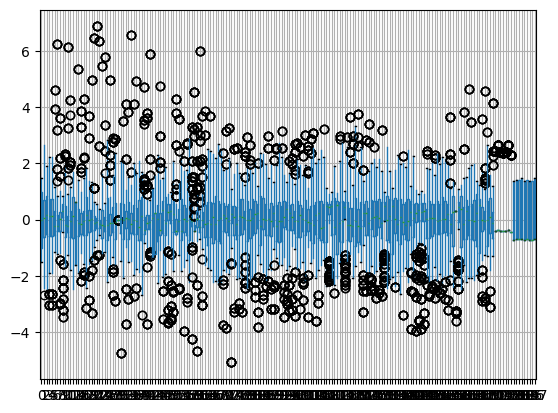

In [167]:
# _X_train.boxplot(figsize=(20,5))
pd.DataFrame(X_train).boxplot()
plt.show()

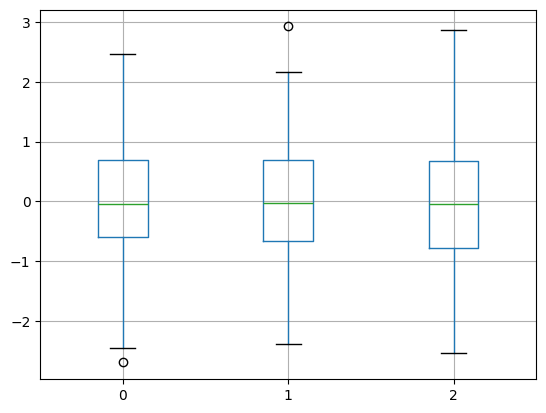

In [168]:
pd.DataFrame(Y_train).boxplot()
plt.show()

In [169]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor


model_params = {
    "kernel": "linear",
    "C": 2119.7634277188213,
    # "C": 1,
    "gamma": 0.0023517959671016664,
    "epsilon": 0.01598581077956493,
    "coef0": -0.6434038475318813,
    "degree": 3,
    "shrinking": True,
}
reg = MultiOutputRegressor(estimator=SVR(**model_params, verbose=True, max_iter=int(1e5)))
# reg = MultiOutputRegressor(estimator=LinearRegression())
# reg = MultiOutputRegressor(
#     estimator=RandomForestRegressor(n_estimators=200, random_state=0)
# )
# reg = MultiOutputRegressor(
#     estimator=GradientBoostingRegressor(n_estimators=200, random_state=0, max_depth=5)
# )
# reg = MultiOutputRegressor(
#     estimator=XGBRegressor(n_estimators=200, random_state=0, max_depth=1)
# )

In [170]:
reg.fit(X_train, Y_train)

[LibSVM]

c:\Users\admin\Coding\research\weld-ml\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[LibSVM]

c:\Users\admin\Coding\research\weld-ml\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[LibSVM]

c:\Users\admin\Coding\research\weld-ml\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MultiOutputRegressor(estimator=SVR(C=2119.7634277188213,
                                   coef0=-0.6434038475318813,
                                   epsilon=0.01598581077956493,
                                   gamma=0.0023517959671016664, kernel='linear',
                                   max_iter=100000, verbose=True))

In [171]:
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

print(Y_train_pred.shape)
print(Y_test_pred.shape)

(264, 3)
(114, 3)


In [172]:
def eval_perf(y_true, y_pred):
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    return mse, mape, r2


def print_perf(data):
    for k, v in data.items():
        print(k, ":", v)


data_arr = []
for i in range(0, _Y.shape[1]):
    mse_train, mape_train, r2_train = eval_perf(
        y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
    )
    mse_test, mape_test, r2_test = eval_perf(
        y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
    )

    data = {
        "Y": f"Y-{i + 1}",
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "MAPE Train": mape_train,
        "MAPE Test": mape_test,
        "R2 Train": r2_train,
        "R2 Test": r2_test,
    }
    # print_perf(data)

    data_arr.append(data)

mse_train, mape_train, r2_train = eval_perf(y_true=Y_train, y_pred=Y_train_pred)
mse_test, mape_test, r2_test = eval_perf(y_true=Y_test, y_pred=Y_test_pred)
print_perf(data)

data = {
    "Y": "Y-All",
    "MSE Train": mse_train,
    "MSE Test": mse_test,
    "MAPE Train": mape_train,
    "MAPE Test": mape_test,
    "R2 Train": r2_train,
    "R2 Test": r2_test,
}
data_arr.append(data)
# print_perf(data)

df_eval = pd.DataFrame.from_dict(data_arr)
display(df_eval)

if SAVE_DATA:
    filename = f"eval_{dt}.xlsx"
    df_eval.to_excel(filename, index=False)

Y : Y-3
MSE Train : 1.2804469377187713
MSE Test : 1.1022175191218355
MAPE Train : 2.7986065358553374
MAPE Test : 3.3012595380691887
R2 Train : -0.2804469377187724
R2 Test : -0.1700124391486515


,Y,MSE Train,MSE Test,MAPE Train,MAPE Test,R2 Train,R2 Test
0,Y-1,1.588509,1.662841,3.092169,3.412629,-0.588509,-1.086987
1,Y-2,2.101326,1.901673,2.540949,11.458716,-1.101326,-0.823231
2,Y-3,1.280447,1.102218,2.798607,3.301260,-0.280447,-0.170012
3,Y-All,1.656761,1.555577,2.810575,6.057535,-0.656761,-0.693410


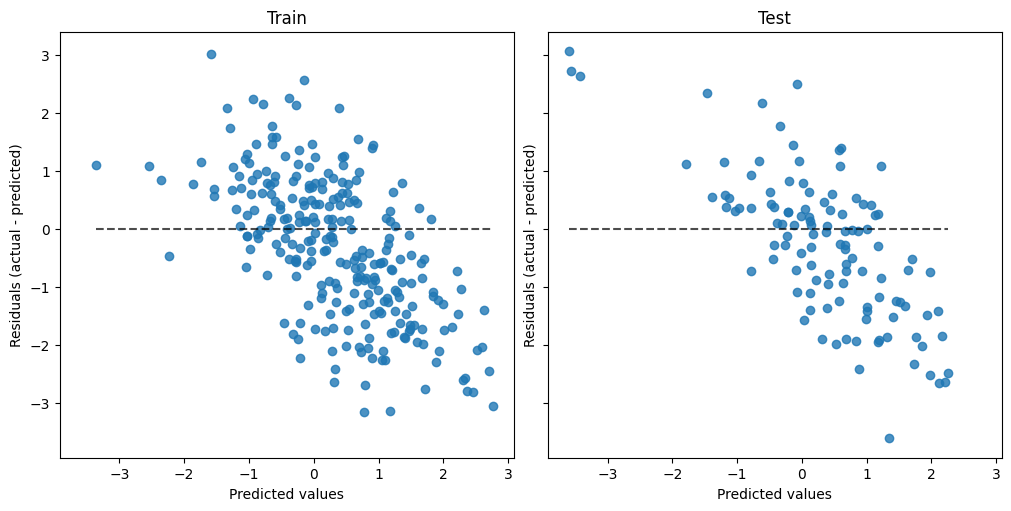

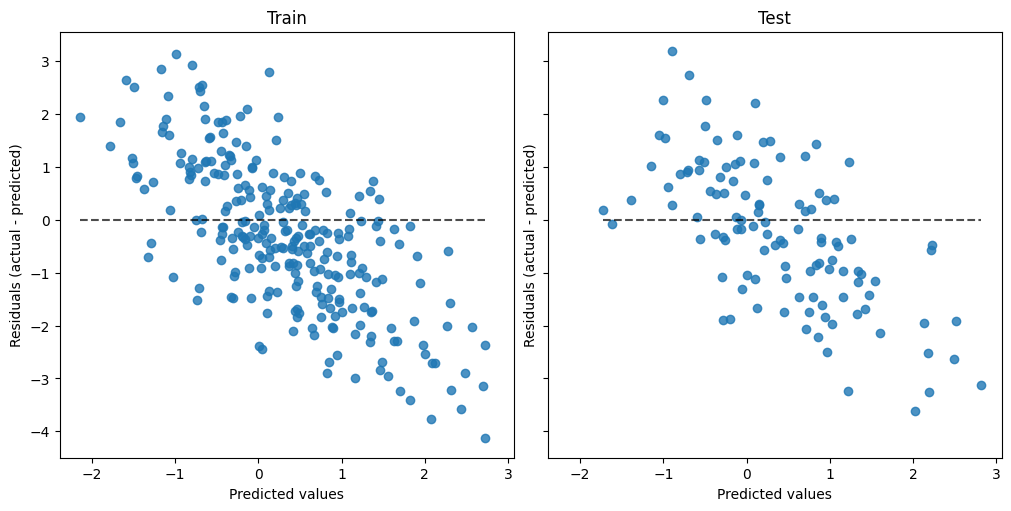

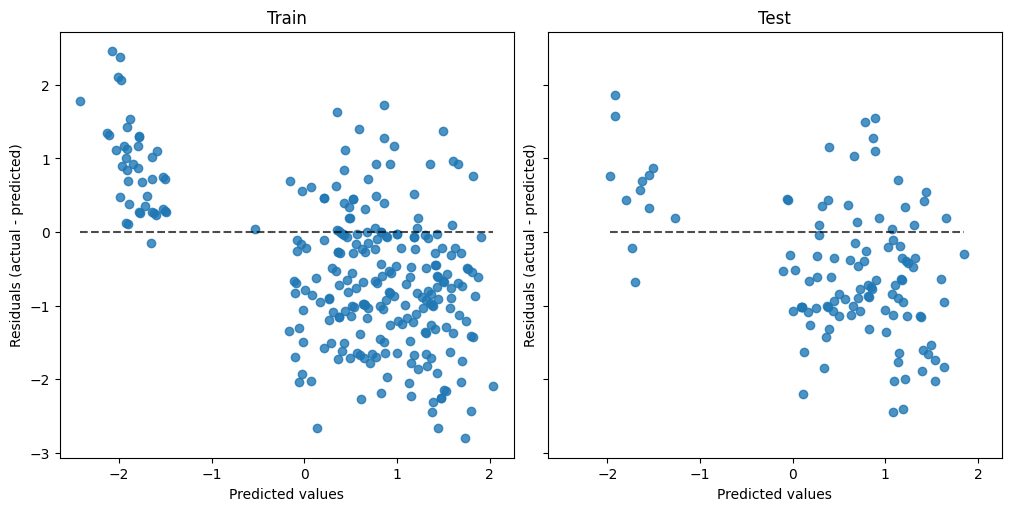

In [173]:
for i in range(0, _Y.shape[1]):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(10, 5),
        constrained_layout=True,
        sharex=True,
        sharey=True,
    )

    display_train = PredictionErrorDisplay(
        y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
    )
    display_train.plot(ax=axes[0])
    axes[0].set_title("Train")

    display_train = PredictionErrorDisplay(
        y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
    )
    display_train.plot(ax=axes[1])
    axes[1].set_title("Test")

    if SAVE_DATA:
        filename = f"res_plot_{dt}_{i}.png"
        fig.savefig(filename, dpi=300)

    plt.show()